# Covariance structure analysis under different spatial random processes and autocorrelation parameters (Fig S3)

In [1]:
import itertools
from functools import partial
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from plotnine import *

import smoother
from smoother import SpatialWeightMatrix, SpatialLoss
from smoother.utils import *

import scanpy as sc
import anndata

In [2]:
data_dir = "/Users/jysumac/Projects/Smoother_paper/data/breast_cancer_visium/"

## Load and preprocess data (breast cancer)

In [3]:
from matplotlib.image import imread
import json

def read_sp_data(data_dir, sample_id):
    count_dir = data_dir + \
        f"/filtered_count_matrices/{sample_id}_filtered_count_matrix/"
    sp_dir = data_dir + f"/spatial/{sample_id}_spatial/"
    meta_dir = data_dir + f"/metadata/{sample_id}_metadata.csv"
    
    # load counts
    adata = sc.read_10x_mtx(count_dir)
    
    # load spatial data
    adata.uns["spatial"] = dict()
    adata.uns["spatial"][sample_id] = dict()

    files = dict(
        tissue_positions_file = sp_dir + '/tissue_positions_list.csv',
        scalefactors_json_file = sp_dir + '/scalefactors_json.json',
        hires_image = sp_dir + '/tissue_hires_image.png',
        lowres_image = sp_dir  + '/tissue_lowres_image.png',
    )

    adata.uns["spatial"][sample_id]['images'] = dict()

    for res in ['hires', 'lowres']:
        try:
            adata.uns["spatial"][sample_id]['images'][res] = imread(
                str(files[f'{res}_image'])
            )
        except Exception:
            raise OSError(f"Could not find '{res}_image'")

    # read json scalefactors
    with open(files['scalefactors_json_file']) as f:
        js = json.load(f)
    adata.uns["spatial"][sample_id]['scalefactors'] = js

    # read coordinates
    positions = pd.read_csv(files['tissue_positions_file'], header=None)
    positions.columns = [
        'barcode',
        'in_tissue',
        'array_row',
        'array_col',
        'pxl_col_in_fullres',
        'pxl_row_in_fullres',
    ]
    positions.index = positions['barcode']

    adata.obs = adata.obs.join(positions, how="left")

    adata.obsm['spatial'] = adata.obs[
        ['pxl_row_in_fullres', 'pxl_col_in_fullres']
    ].to_numpy()
    adata.obs.drop(
        columns=['barcode', 'pxl_row_in_fullres', 'pxl_col_in_fullres'],
        inplace=True,
    )
    
    # load meta
    meta = pd.read_csv(meta_dir, header=0, sep=',', index_col=0)
    adata.obs = adata.obs.join(meta, how="left")
    
    return adata

### Load and preprocess data

In [4]:
sample_id = "1160920F"
adata = read_sp_data(data_dir, sample_id)

In [5]:
adata.var['mt'] = adata.var_names.str.startswith("MT-")
sc.pp.calculate_qc_metrics(adata, qc_vars=["mt"], inplace=True)

sc.pp.filter_genes(adata, min_cells=10)
sc.pp.normalize_total(adata, inplace=True)
sc.pp.log1p(adata)
sc.pp.highly_variable_genes(adata, flavor="seurat", n_top_genes=2000)

### Prepare inputs

In [6]:
img = adata.uns["spatial"][sample_id]['images']['hires']
sf = adata.uns["spatial"][sample_id]['scalefactors']
yy = torch.tensor(adata.X[:,adata.var['highly_variable']].toarray().T)

# spatial coordinates
pixels = adata.obsm['spatial']

## Correlation decay

### Quick visualization of the effect of scaling (ICAR, rho = 0.99)

In [7]:
# calculate weight matrix
w_raw = SpatialWeightMatrix()
w_raw.calc_weights_knn(pixels, k=6)

# knn + expression (cosine)
w_exp = SpatialWeightMatrix()
w_exp.calc_weights_knn(pixels, k=6)
w_exp.scale_by_expr(yy)

# knn + histology (pca)
w_hist = SpatialWeightMatrix()
w_hist.calc_weights_knn(pixels, k = 6)
w_hist.scale_by_histology(pixels, img, sf)

# convert to spatial loss
spl_raw = SpatialLoss('icar', w_raw, rho = 0.99)
spl_exp = SpatialLoss('icar', w_exp, rho = 0.99)
spl_hist = SpatialLoss('icar', w_hist, rho = 0.99)

Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.89.
Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.88.


In [8]:
spl_list = [spl_raw, spl_exp, spl_hist]
scaling_list = ['Raw', 'Soft-scaled by expression', 'Soft-scaled by histology']
corr_all_df = []
var_all_df = []

for i, loss in enumerate(spl_list):
    corr_decay_quantiles_df, var_quantiles_df = loss.calc_corr_decay_stats(coords=pixels, return_var=True)
    corr_decay_quantiles_df['scaling'] = scaling_list[i]
    var_quantiles_df['scaling'] = scaling_list[i]
    
    corr_all_df.append(corr_decay_quantiles_df)
    var_all_df.append(var_quantiles_df)

corr_all_df = pd.concat(corr_all_df)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 170.20it/s]


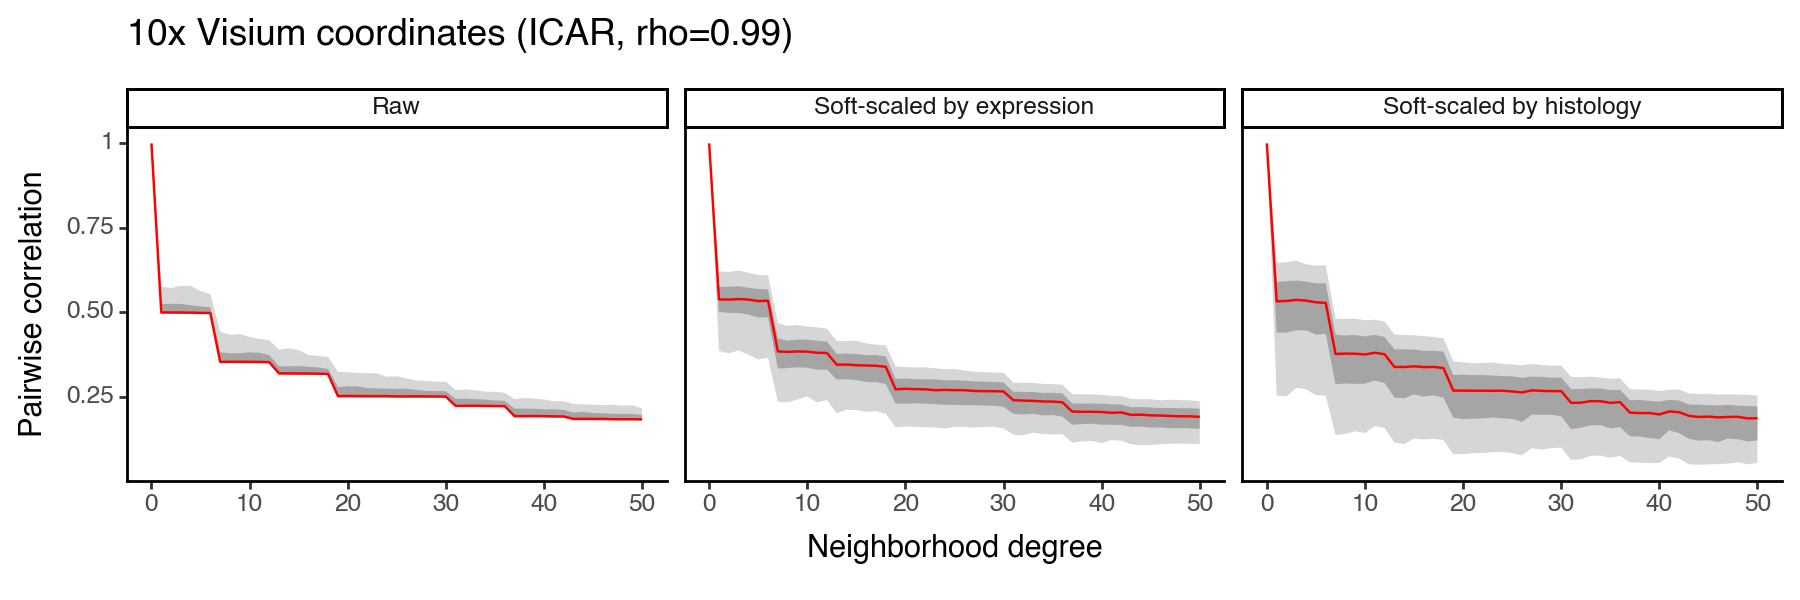

<Figure Size: (900 x 300)>

In [9]:
(
    ggplot(corr_all_df, aes(x = 'k')) + 
    facet_wrap('~scaling', nrow = 1) +
    geom_ribbon(aes(x = 'k', ymin = 'Q10', ymax = 'Q90'), alpha = 0.2) + 
    geom_ribbon(aes(x = 'k', ymin = 'Q25', ymax = 'Q75'), alpha = 0.3) + 
    geom_line(aes(x = 'k', y = 'Q50'), color = "red") + 
    labs(
        x = "Neighborhood degree", y = "Pairwise correlation",
        title = "10x Visium coordinates (ICAR, rho=0.99)"
    ) + 
    theme_classic() + 
    theme(figure_size = (9,3))
)

### No pruning

#### Create spatial weights matrix

In [10]:
swm_list = []
ks_knn = [6, 18]
bws_eu = [0.1, 0.01]

# KNN
for k in ks_knn:
    swm = SpatialWeightMatrix()
    swm.calc_weights_knn(pixels, k=k)
    swm_list.append(swm)

for bw in bws_eu:
    swm = SpatialWeightMatrix()
    swm.calc_weights_dist(pixels, band_width=bw, radius_cutoff=500)
    swm_list.append(swm)

Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  17.54.
Number of spots: 4895. Average number of neighbors per spot:  11.63.
Number of spots: 4895. Average number of neighbors per spot:  11.63.


#### Create spatial loss

In [11]:
priors = ['icar', 'isar', 'sma']
rhos = [0, 0.5, 0.75, 0.9, 0.99, 0.999]

spl_list = []
for prior, rho, swm in itertools.product(priors, rhos, swm_list):
    if not prior == 'sma':
        spl = SpatialLoss(prior=prior, rho=rho, spatial_weights=swm)
    else:
        spl = SpatialLoss(prior=prior, rho=rho, spatial_weights=swm, use_sparse=False)
    spl_list.append(spl)

/Users/jysumac/Projects/Smoother/smoother/weights.py:262: UserWarning: Sparse CSR tensor support is in beta state. If you miss a functionality in the sparse tensor support, please submit a feature request to https://github.com/pytorch/pytorch/issues. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/SparseCsrTensorImpl.cpp:56.)


#### Calculate correlation decay

In [12]:
df_corr_raw = []
df_var_raw = []
swm_names = [f'KNN (k={k})' for k in ks_knn] + [f'Euclidean (bw={bw})' for bw in bws_eu]

for i, (prior, rho, name) in enumerate(itertools.product(priors, rhos, swm_names)):
    try:
        corr_decay_quantiles_df, var_quantiles_df = \
            spl_list[i].calc_corr_decay_stats(coords=pixels, return_var=True)

        corr_decay_quantiles_df['prior'] = prior
        corr_decay_quantiles_df['rho'] = rho
        corr_decay_quantiles_df['dist_metric'] = name
        var_quantiles_df['prior'] = prior
        var_quantiles_df['rho'] = rho
        var_quantiles_df['dist_metric'] = name
        
        df_corr_raw.append(corr_decay_quantiles_df)
        df_var_raw.append(var_quantiles_df)
    except Exception as err:
        print(err)
        continue

df_corr_raw = pd.concat(df_corr_raw)
df_var_raw = pd.concat(df_var_raw)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 167.99it/s]


The current loss (icar, rho=0.99) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.
The current loss (icar, rho=0.99) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 165.18it/s]


The current loss (icar, rho=0.999) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.
The current loss (icar, rho=0.999) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 171.49it/s]


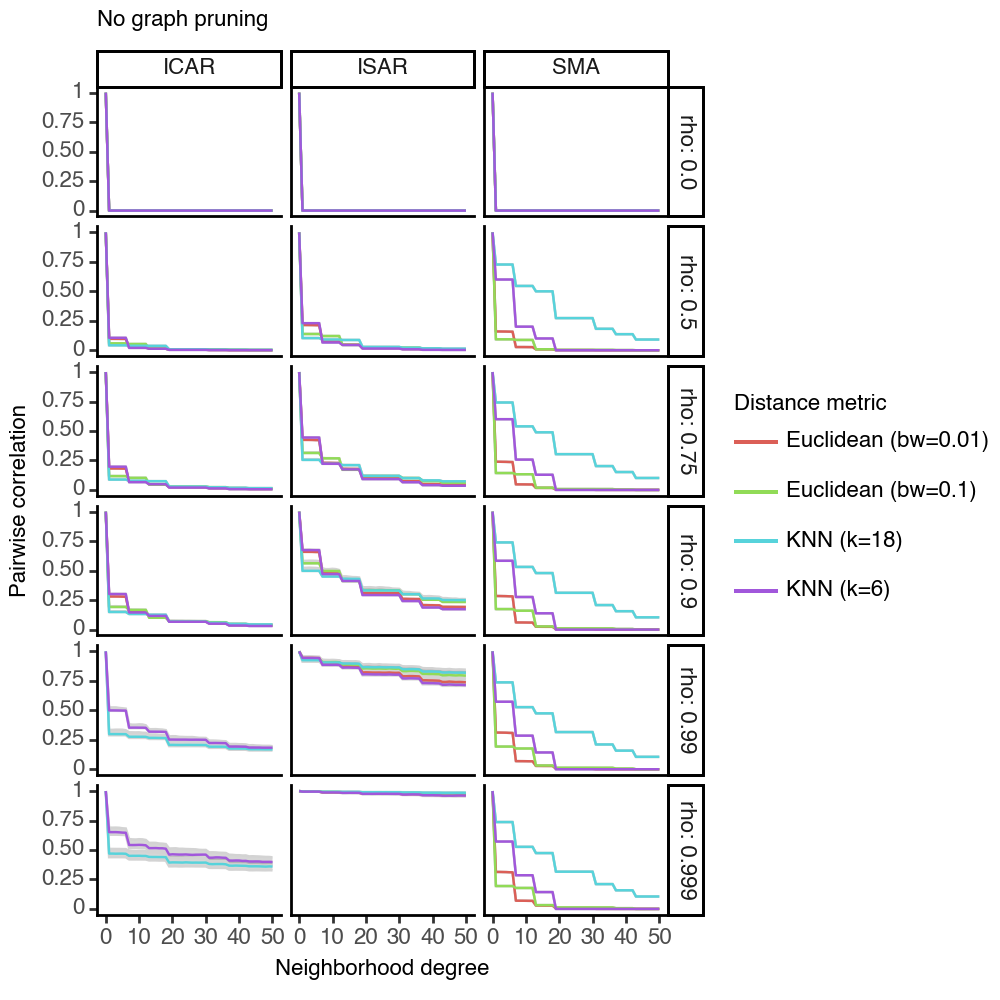

<Figure Size: (500 x 500)>

In [13]:
(
    ggplot(df_corr_raw, aes(x = 'k', group = 'dist_metric')) + 
    facet_grid('rho~ prior', labeller = labeller(cols = str.upper, rows=label_both)) +
    geom_ribbon(aes(x = 'k', ymin = 'Q25', ymax = 'Q75'), color = 'lightgrey', alpha = 0.2) + 
    geom_line(aes(x = 'k', y = 'Q50', color = 'dist_metric')) + 
    labs(
        x = "Neighborhood degree", y = "Pairwise correlation",
        title = "No graph pruning",
        color = 'Distance metric'
    ) + 
    theme_classic() + 
    theme(figure_size = (5,5),
         text=element_text(size=8))
)

#### Calculate exponential decay rate

In [14]:
estimate_decay_rate(corr_decay_quantiles_df['k'], corr_decay_quantiles_df['Q75'])

0.27149812262625683

In [15]:
def _calc_beta(selected, df):
    try:
        idx = (df['prior'] == selected['prior']) & \
            (df['rho'] == selected['rho']) & \
            (df['dist_metric'] == selected['dist_metric'])
    
        df_sub = df[idx][['k', 'Q50']]
        beta = estimate_decay_rate(df_sub['k'], df_sub['Q50'])
    except Exception as err:
        print(err)
        beta = pd.NA
    return beta

In [16]:
priors = ['icar', 'isar', 'sma']
rhos = [0.5, 0.75, 0.9, 0.99, 0.999]
dist_metrics = ['KNN (k=6)', 'KNN (k=18)',
                'Euclidean (bw=0.1)', 'Euclidean (bw=0.01)']

selected_df = pd.MultiIndex.from_product(
    [priors, rhos, dist_metrics], 
    names = ['prior', 'rho', 'dist_metric'])

df_beta_raw = pd.DataFrame(index = selected_df).reset_index()
df_beta_raw['beta'] = df_beta_raw.apply(partial(_calc_beta, df = df_corr_raw), axis = 1)
df_beta_raw = df_beta_raw.dropna()
df_beta_raw['beta'] = df_beta_raw['beta'].astype(float)
df_beta_raw['prior'] = df_beta_raw['prior'].str.upper()

`ydata` must not be empty!
`ydata` must not be empty!
`ydata` must not be empty!
`ydata` must not be empty!


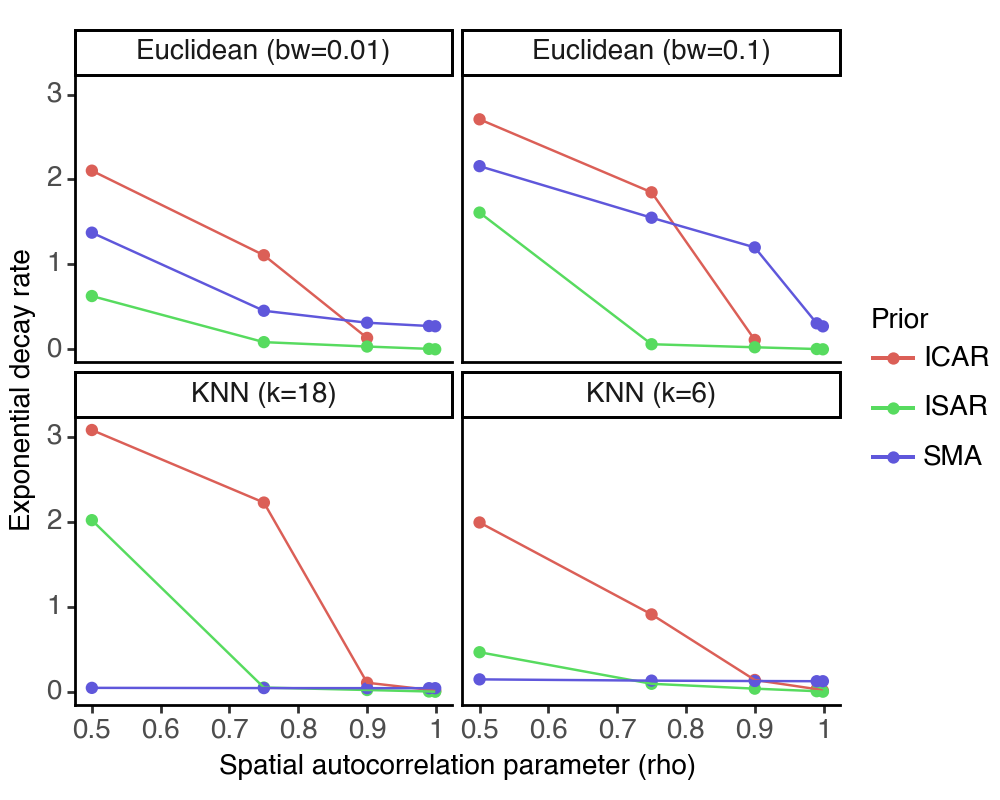

<Figure Size: (500 x 400)>

In [17]:
(
    ggplot(df_beta_raw, aes(x = 'rho', y = 'beta', color = 'prior', group = 'prior')) + 
    facet_wrap('~dist_metric', ncol = 2) +
    geom_point() +
    geom_line() +
    labs(color = 'Prior', x = 'Spatial autocorrelation parameter (rho)', y = 'Exponential decay rate') +
    theme_classic() +
    theme(figure_size = (5,4),
         text=element_text(size=10))
)

### Soft scaling by expression

#### Create spatial weights matrix

In [18]:
swm_list = []
ks_knn = [6, 18]
bws_eu = [0.1, 0.01]

# KNN
for k in ks_knn:
    swm = SpatialWeightMatrix()
    swm.calc_weights_knn(pixels, k=k)
    swm.scale_by_expr(yy)
    swm_list.append(swm)

for bw in bws_eu:
    swm = SpatialWeightMatrix()
    swm.calc_weights_dist(pixels, band_width=bw, radius_cutoff=500)
    swm.scale_by_expr(yy)
    swm_list.append(swm)

Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.89.
Number of spots: 4895. Average number of neighbors per spot:  17.54.
Number of spots: 4895. Average number of neighbors per spot:  17.54.
Number of spots: 4895. Average number of neighbors per spot:  11.63.
Number of spots: 4895. Average number of neighbors per spot:  11.63.
Number of spots: 4895. Average number of neighbors per spot:  11.63.
Number of spots: 4895. Average number of neighbors per spot:  11.63.


#### Create spatial loss

In [19]:
priors = ['icar', 'isar', 'sma']
rhos = [0, 0.5, 0.75, 0.9, 0.99, 0.999]

spl_list = []
for prior, rho, swm in itertools.product(priors, rhos, swm_list):
    if not prior == 'sma':
        spl = SpatialLoss(prior=prior, rho=rho, spatial_weights=swm)
    else:
        spl = SpatialLoss(prior=prior, rho=rho, spatial_weights=swm, use_sparse=False)
    spl_list.append(spl)

#### Calculate correlation decay

In [20]:
df_corr_exp = []
df_var_exp = []
swm_names = [f'KNN (k={k})' for k in ks_knn] + [f'Euclidean (bw={bw})' for bw in bws_eu]

for i, (prior, rho, name) in enumerate(itertools.product(priors, rhos, swm_names)):
    try:
        corr_decay_quantiles_df, var_quantiles_df = \
            spl_list[i].calc_corr_decay_stats(coords=pixels, return_var=True)

        corr_decay_quantiles_df['prior'] = prior
        corr_decay_quantiles_df['rho'] = rho
        corr_decay_quantiles_df['dist_metric'] = name
        var_quantiles_df['prior'] = prior
        var_quantiles_df['rho'] = rho
        var_quantiles_df['dist_metric'] = name
        
        df_corr_exp.append(corr_decay_quantiles_df)
        df_var_exp.append(var_quantiles_df)
    except Exception as err:
        print(err)
        continue

df_corr_exp = pd.concat(df_corr_exp)
df_var_exp = pd.concat(df_var_exp)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 154.18it/s]


The current loss (icar, rho=0.99) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.
The current loss (icar, rho=0.99) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 154.68it/s]


The current loss (icar, rho=0.999) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.
The current loss (icar, rho=0.999) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 155.55it/s]


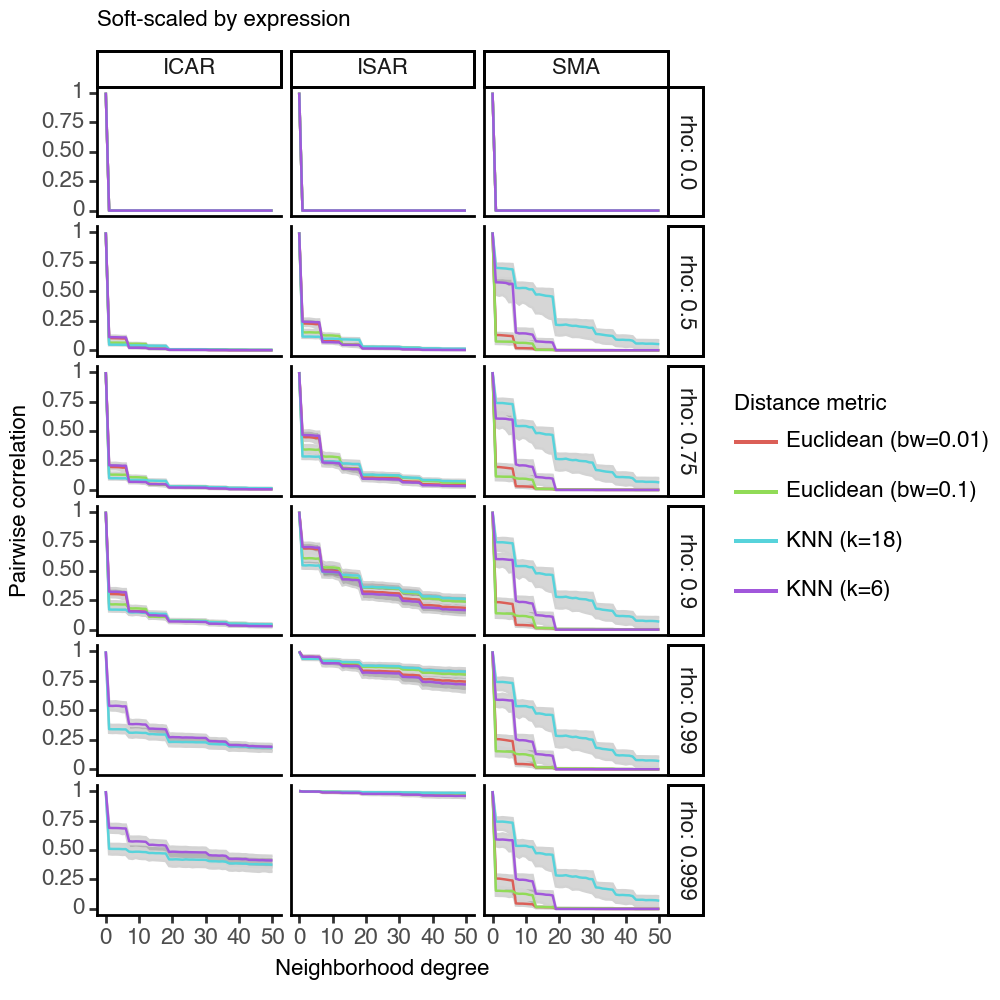

<Figure Size: (500 x 500)>

In [21]:
(
    ggplot(df_corr_exp, aes(x = 'k', group = 'dist_metric')) + 
    facet_grid('rho~ prior', labeller = labeller(cols = str.upper, rows=label_both)) +
    geom_ribbon(aes(x = 'k', ymin = 'Q25', ymax = 'Q75'), color = 'lightgrey', alpha = 0.2) + 
    geom_line(aes(x = 'k', y = 'Q50', color = 'dist_metric')) + 
    labs(
        x = "Neighborhood degree", y = "Pairwise correlation",
        title = "Soft-scaled by expression",
        color = 'Distance metric'
    ) + 
    theme_classic() + 
    theme(figure_size = (5,5),
         text=element_text(size=8))
)

#### Calculate exponential decay rate

In [22]:
estimate_decay_rate(corr_decay_quantiles_df['k'], corr_decay_quantiles_df['Q75'])

0.31366463418906343

In [23]:
def _calc_beta(selected, df):
    try:
        idx = (df['prior'] == selected['prior']) & \
            (df['rho'] == selected['rho']) & \
            (df['dist_metric'] == selected['dist_metric'])
    
        df_sub = df[idx][['k', 'Q50']]
        beta = estimate_decay_rate(df_sub['k'], df_sub['Q50'])
    except Exception as err:
        print(err)
        beta = pd.NA
    return beta

In [24]:
priors = ['icar', 'isar', 'sma']
rhos = [0.5, 0.75, 0.9, 0.99, 0.999]
dist_metrics = ['KNN (k=6)', 'KNN (k=18)',
                'Euclidean (bw=0.1)', 'Euclidean (bw=0.01)']

selected_df = pd.MultiIndex.from_product(
    [priors, rhos, dist_metrics], 
    names = ['prior', 'rho', 'dist_metric'])
df_beta_exp = pd.DataFrame(index = selected_df).reset_index()
df_beta_exp['beta'] = df_beta_exp.apply(partial(_calc_beta, df = df_corr_exp), axis = 1)
df_beta_exp = df_beta_exp.dropna()
df_beta_exp['beta'] = df_beta_exp['beta'].astype(float)
df_beta_exp['prior'] = df_beta_exp['prior'].str.upper()

`ydata` must not be empty!
`ydata` must not be empty!
`ydata` must not be empty!
`ydata` must not be empty!


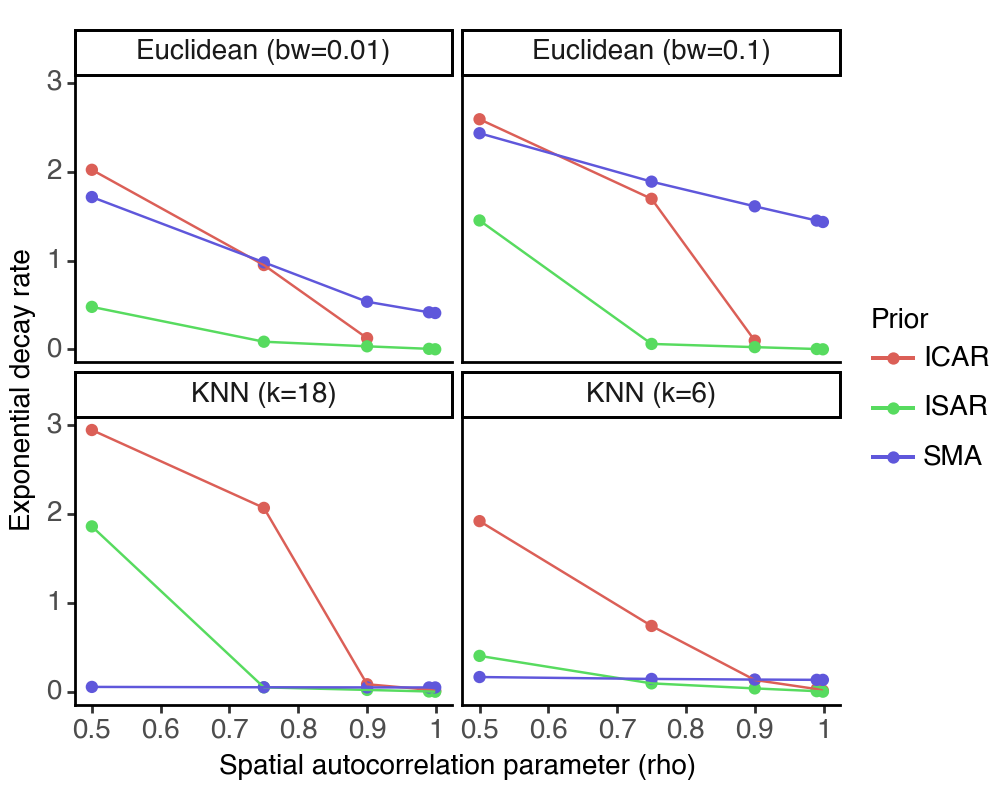

<Figure Size: (500 x 400)>

In [25]:
(
    ggplot(df_beta_exp, aes(x = 'rho', y = 'beta', color = 'prior', group = 'prior')) + 
    facet_wrap('~dist_metric', ncol = 2) +
    geom_point() +
    geom_line() +
    labs(color = 'Prior', x = 'Spatial autocorrelation parameter (rho)', y = 'Exponential decay rate') +
    theme_classic() +
    theme(figure_size = (5,4),
         text = element_text(size=10))
)

### Soft scaling by histology

#### Create spatial weights matrix

In [26]:
swm_list = []
ks_knn = [6, 18]
bws_eu = [0.1, 0.01]

# KNN
for k in ks_knn:
    swm = SpatialWeightMatrix()
    swm.calc_weights_knn(pixels, k=k)
    swm.scale_by_histology(pixels, img, sf)
    swm_list.append(swm)

for bw in bws_eu:
    swm = SpatialWeightMatrix()
    swm.calc_weights_dist(pixels, band_width=bw, radius_cutoff=500)
    swm.scale_by_histology(pixels, img, sf)
    swm_list.append(swm)

Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  5.88.
Number of spots: 4895. Average number of neighbors per spot:  17.54.
Number of spots: 4895. Average number of neighbors per spot:  17.54.
Number of spots: 4895. Average number of neighbors per spot:  11.63.
Number of spots: 4895. Average number of neighbors per spot:  11.63.
Number of spots: 4895. Average number of neighbors per spot:  11.63.
Number of spots: 4895. Average number of neighbors per spot:  11.63.


#### Create spatial loss

In [27]:
priors = ['icar', 'isar', 'sma']
rhos = [0, 0.5, 0.75, 0.9, 0.99, 0.999]

spl_list = []
for prior, rho, swm in itertools.product(priors, rhos, swm_list):
    if not prior == 'sma':
        spl = SpatialLoss(prior=prior, rho=rho, spatial_weights=swm)
    else:
        spl = SpatialLoss(prior=prior, rho=rho, spatial_weights=swm, use_sparse=False)
    spl_list.append(spl)

#### Calculate correlation decay

In [28]:
df_corr_hist = []
df_var_hist = []
swm_names = [f'KNN (k={k})' for k in ks_knn] + [f'Euclidean (bw={bw})' for bw in bws_eu]

for i, (prior, rho, name) in enumerate(itertools.product(priors, rhos, swm_names)):
    try:
        corr_decay_quantiles_df, var_quantiles_df = \
            spl_list[i].calc_corr_decay_stats(coords=pixels, return_var=True)

        corr_decay_quantiles_df['prior'] = prior
        corr_decay_quantiles_df['rho'] = rho
        corr_decay_quantiles_df['dist_metric'] = name
        var_quantiles_df['prior'] = prior
        var_quantiles_df['rho'] = rho
        var_quantiles_df['dist_metric'] = name
        
        df_corr_hist.append(corr_decay_quantiles_df)
        df_var_hist.append(var_quantiles_df)
    except Exception as err:
        print(err)
        continue

df_corr_hist = pd.concat(df_corr_hist)
df_var_hist = pd.concat(df_var_hist)

100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 213.82it/s]


The current loss (icar, rho=0.75) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 203.85it/s]


The current loss (icar, rho=0.9) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.
The current loss (icar, rho=0.9) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 214.96it/s]


The current loss (icar, rho=0.99) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.
The current loss (icar, rho=0.99) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 213.09it/s]


The current loss (icar, rho=0.999) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.
The current loss (icar, rho=0.999) contains an improper spatial covariance structure. Please use a different spatial prior or scale if you intend to calculate covariance decay.


100%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 51/51 [00:00<00:00, 214.74it/s]


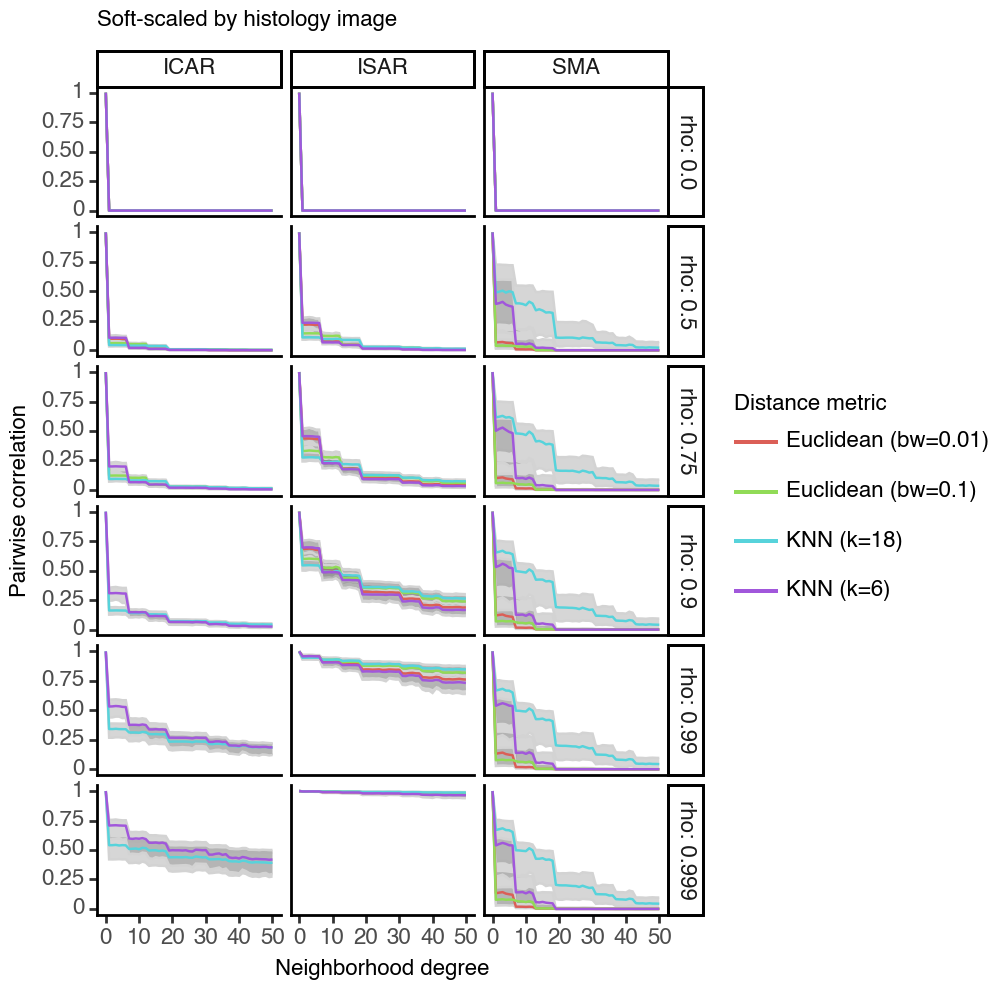

<Figure Size: (500 x 500)>

In [29]:
(
    ggplot(df_corr_hist, aes(x = 'k', group = 'dist_metric')) + 
    facet_grid('rho~ prior', labeller = labeller(cols = str.upper, rows=label_both)) +
    geom_ribbon(aes(x = 'k', ymin = 'Q25', ymax = 'Q75'), color = 'lightgrey', alpha = 0.2) + 
    geom_line(aes(x = 'k', y = 'Q50', color = 'dist_metric')) + 
    labs(
        x = "Neighborhood degree", y = "Pairwise correlation",
        title = "Soft-scaled by histology image",
        color = 'Distance metric'
    ) + 
    theme_classic() + 
    theme(figure_size = (5,5),
         text=element_text(size=8))
)

#### Calculate exponential decay rate

In [30]:
estimate_decay_rate(corr_decay_quantiles_df['k'], corr_decay_quantiles_df['Q75'])

0.29808930312048354

In [31]:
def _calc_beta(selected, df):
    try:
        idx = (df['prior'] == selected['prior']) & \
            (df['rho'] == selected['rho']) & \
            (df['dist_metric'] == selected['dist_metric'])
    
        df_sub = df[idx][['k', 'Q50']]
        beta = estimate_decay_rate(df_sub['k'], df_sub['Q50'])
    except Exception as err:
        print(err)
        beta = pd.NA
    return beta

In [32]:
priors = ['icar', 'isar', 'sma']
rhos = [0.5, 0.75, 0.9, 0.99, 0.999]
dist_metrics = ['KNN (k=6)', 'KNN (k=18)',
                'Euclidean (bw=0.1)', 'Euclidean (bw=0.01)']

selected_df = pd.MultiIndex.from_product(
    [priors, rhos, dist_metrics], 
    names = ['prior', 'rho', 'dist_metric'])
df_beta_hist = pd.DataFrame(index = selected_df).reset_index()
df_beta_hist['beta'] = df_beta_hist.apply(partial(_calc_beta, df = df_corr_hist), axis = 1)
df_beta_hist = df_beta_hist.dropna()
df_beta_hist['beta'] = df_beta_hist['beta'].astype(float)
df_beta_hist['prior'] = df_beta_hist['prior'].str.upper()

`ydata` must not be empty!
`ydata` must not be empty!
`ydata` must not be empty!
`ydata` must not be empty!
`ydata` must not be empty!
`ydata` must not be empty!
`ydata` must not be empty!


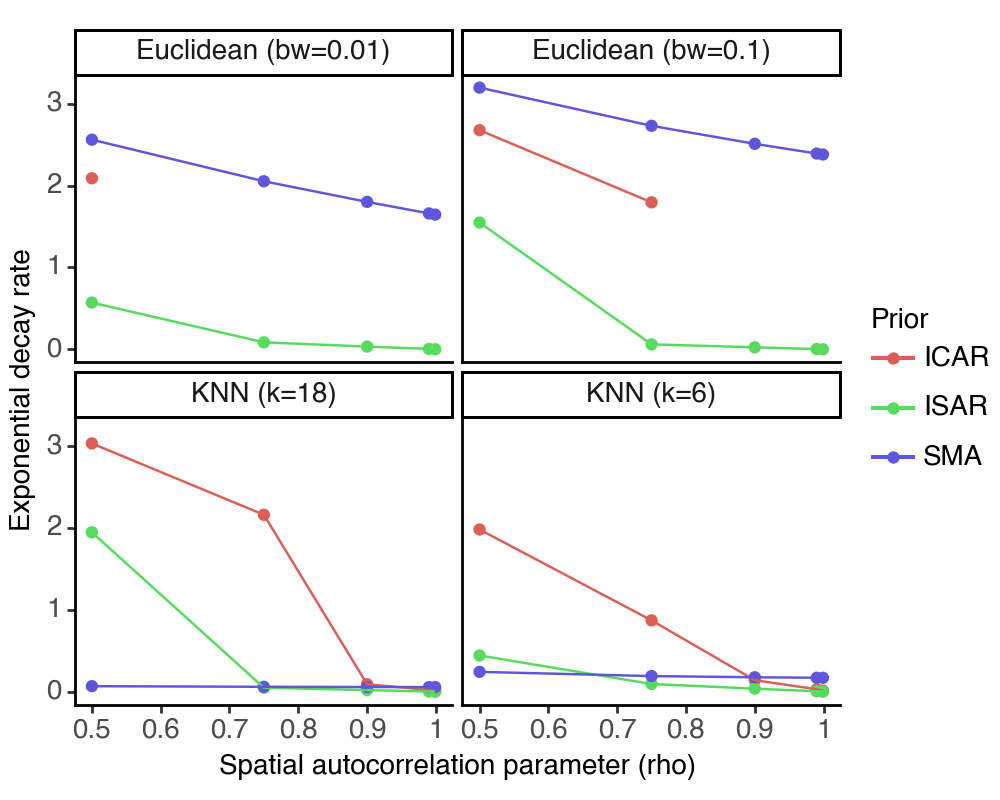

<Figure Size: (500 x 400)>

In [33]:
(
    ggplot(df_beta_hist, aes(x = 'rho', y = 'beta', color = 'prior', group = 'prior')) + 
    facet_wrap('~dist_metric', ncol = 2) +
    geom_point() +
    geom_line() +
    labs(color = 'Prior', x = 'Spatial autocorrelation parameter (rho)', y = 'Exponential decay rate') +
    theme_classic() +
    theme(figure_size = (5,4),
         text = element_text(size=10))
)

## Variance changes

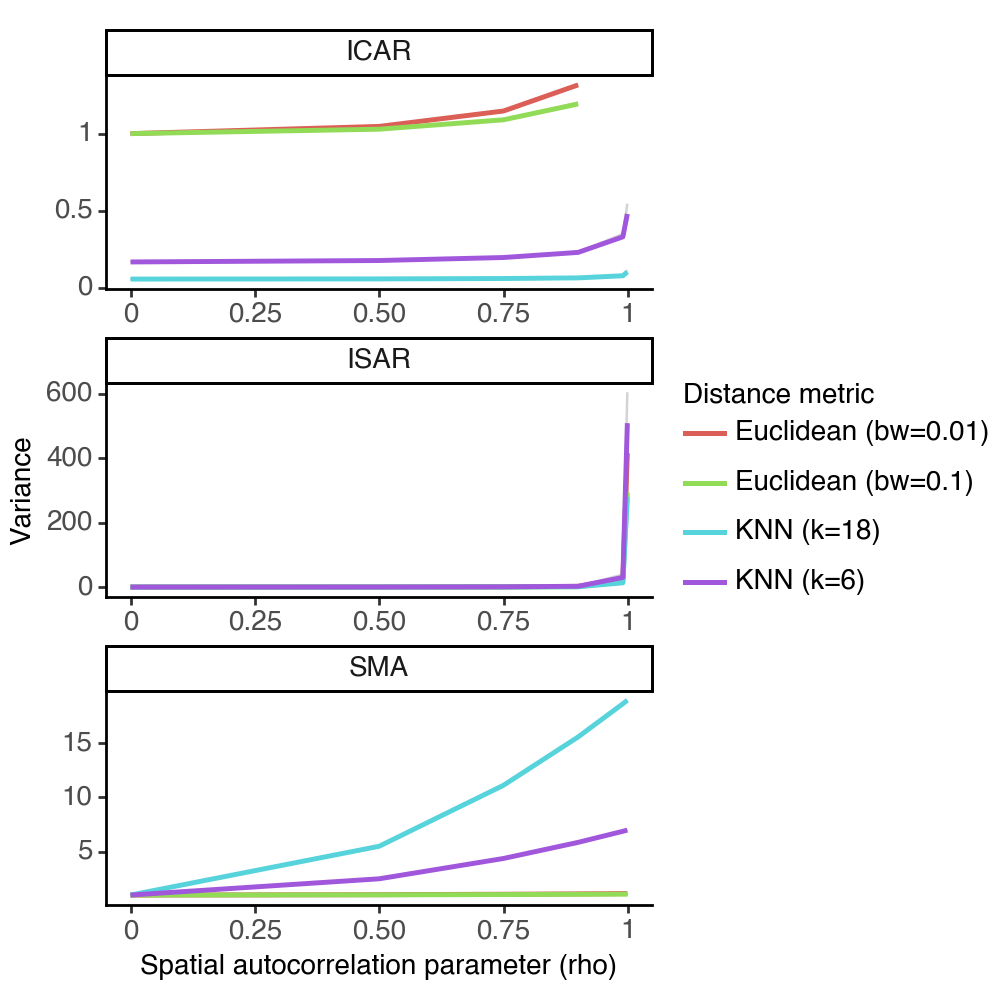

<Figure Size: (500 x 500)>

In [34]:
df_var_raw['prior'] = df_var_raw['prior'].str.upper()
(
    ggplot(df_var_raw,
           aes(x = 'rho', group = 'dist_metric')) +
    facet_wrap('~prior', scales = 'free', ncol=1) +
    geom_ribbon(aes(ymin = 'Q25', ymax = 'Q75'), color = 'lightgrey', alpha = 0.2) + 
    geom_line(aes(y = 'Q50', color = 'dist_metric'), size = 1) + 
    labs(x = 'Spatial autocorrelation parameter (rho)', y = 'Variance', color = 'Distance metric') +
    theme_classic() +
    theme(figure_size=(5, 5),
         text=element_text(size=10))
)

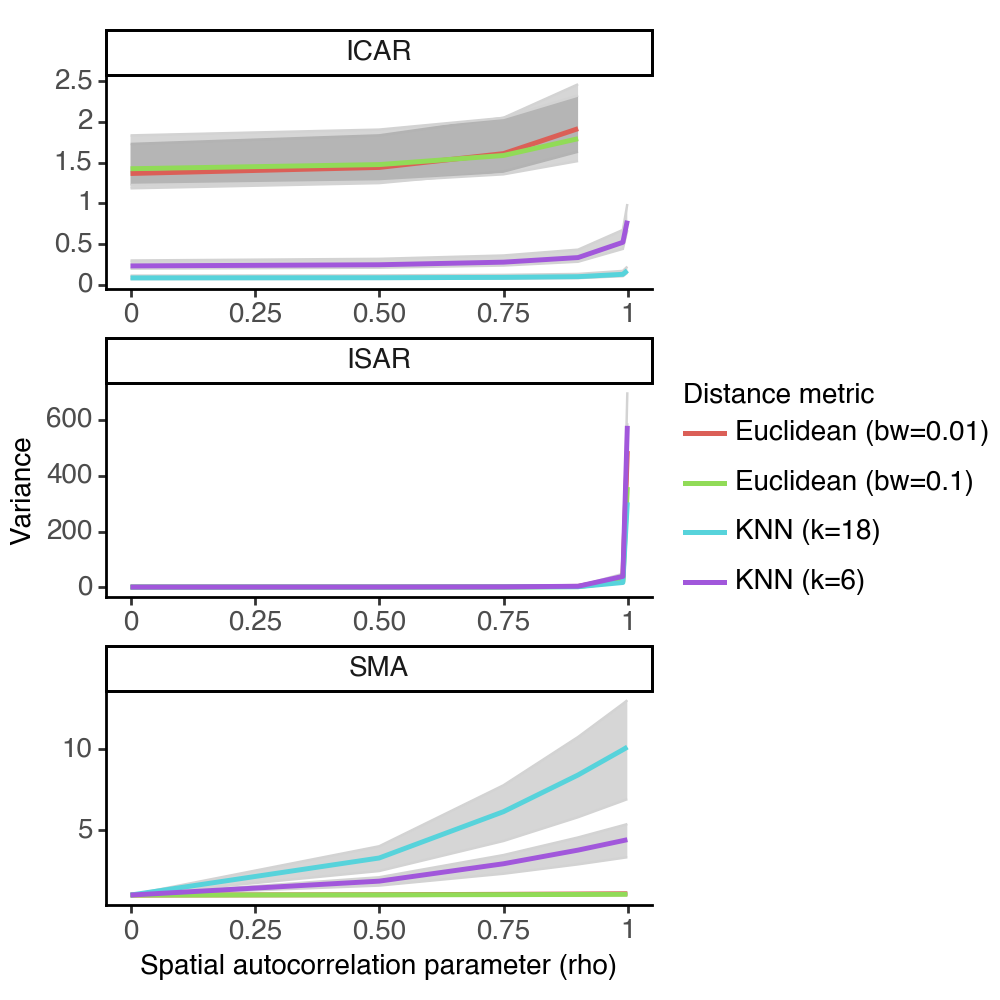

<Figure Size: (500 x 500)>

In [36]:
df_var_exp['prior'] = df_var_exp['prior'].str.upper()
(
    ggplot(df_var_exp,
           aes(x = 'rho', group = 'dist_metric')) +
    facet_wrap('~prior', scales = 'free', ncol=1) +
    geom_ribbon(aes(ymin = 'Q25', ymax = 'Q75'), color = 'lightgrey', alpha = 0.2) + 
    geom_line(aes(y = 'Q50', color = 'dist_metric'), size = 1) + 
    labs(x = 'Spatial autocorrelation parameter (rho)', y = 'Variance', color = 'Distance metric') +
    theme_classic() +
    theme(figure_size=(5, 5),
         text=element_text(size=10))
)

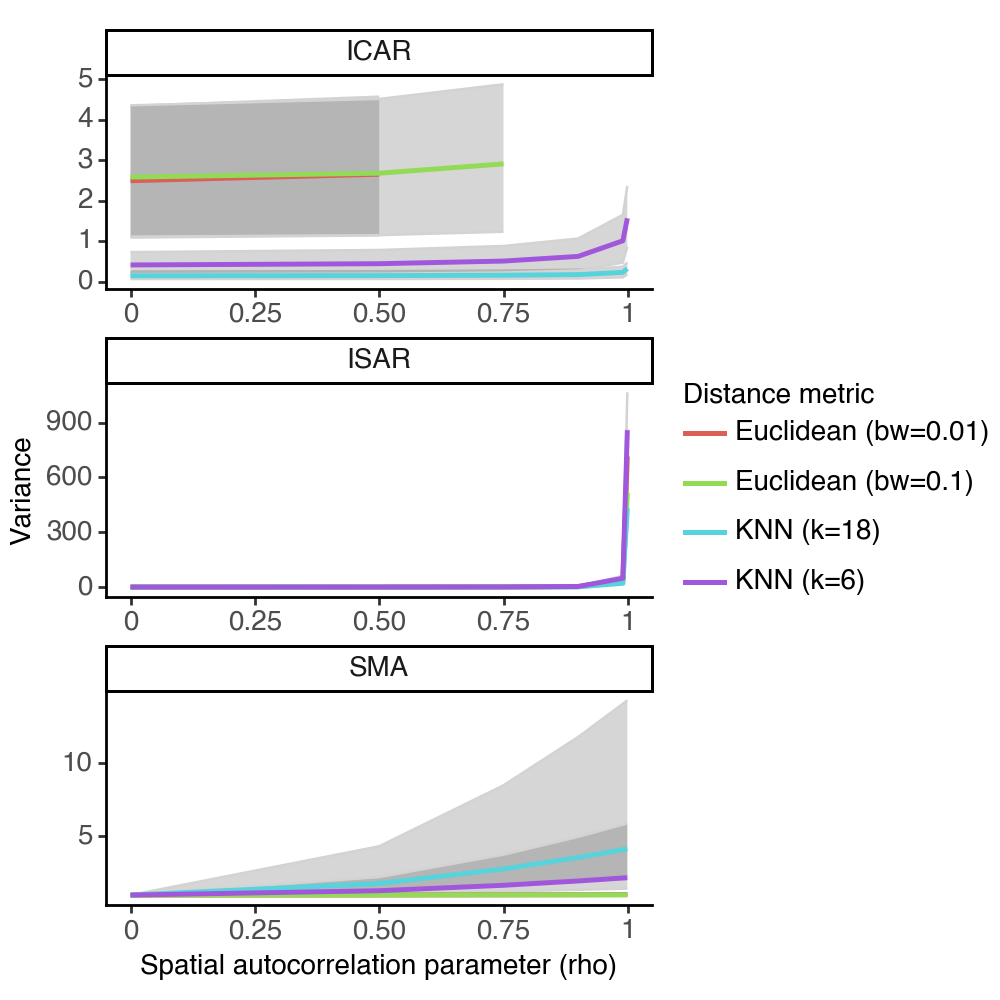

<Figure Size: (500 x 500)>

In [35]:
df_var_hist['prior'] = df_var_hist['prior'].str.upper()
(
    ggplot(df_var_hist,
           aes(x = 'rho', group = 'dist_metric')) +
    facet_wrap('~prior', scales = 'free', ncol=1) +
    geom_ribbon(aes(ymin = 'Q25', ymax = 'Q75'), color = 'lightgrey', alpha = 0.2) + 
    geom_line(aes(y = 'Q50', color = 'dist_metric'), size = 1) + 
    labs(x = 'Spatial autocorrelation parameter (rho)', y = 'Variance', color = 'Distance metric') +
    theme_classic() +
    theme(figure_size=(5, 5),
         text=element_text(size=10))
)